In [9]:
import numpy as np
import pandas as pd
import pickle
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as Log
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics, preprocessing
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.metrics.scorer import make_scorer
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Data Preparation
#### Load the data

In [2]:
# read the data with the non-text features
patents = pd.read_pickle("patent_data/nontext_features_addwordcounts.p")

In [3]:
print patents.shape
patents.head()

(12030, 21)


,id,title,publication_year,B,C,D,E,F,G,H,...,num_patent_citations,num_nonpatent_citations,num_claims,num_similar_doc,num_authors,payment_times,words_title,words_abstract,words_description,words_claims
0,US6699658B1,Yeast cell surface display of proteins and use...,2004,0,1,0,0,0,0,0,...,28,34,42,1,4,3,10,207,519781,954
1,US6699724B1,Metal nanoshells for biosensing applications,2004,0,0,0,0,0,1,0,...,47,44,25,0,4,3,6,179,71698,407
2,US6690816B2,Systems and methods for tubular object process...,2004,0,0,0,0,0,1,0,...,9,0,32,1,4,1,8,114,122503,1105
3,US6711436B1,"Compositions, apparatus and methods for facili...",2004,0,0,0,0,0,0,0,...,105,109,45,7,1,3,9,290,316007,196
4,US6711432B1,Computer-aided orthopedic surgery,2004,0,0,0,0,0,0,0,...,15,114,44,3,4,3,4,139,49083,683


#### Format the data

In [4]:
# reformat the response variable into binary
y_data = np.zeros(patents.shape[0])
y_data[patents['payment_times'].values >= 2] = 1

print "Percentage of patents with > 1 maintenance fee payments: ", np.mean(y_data)

Percentage of patents with > 1 maintenance fee payments:  0.62859517872


In [5]:
# predictors
x_data = patents.drop(['id', 'title', 'payment_times', 'publication_year'], axis = 1).values
x_data.shape

(12030, 17)

In [14]:
# split train and test sets
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size = 2000, 
                                                    random_state = 123)

print "Dataset dimensions:"
print "x_train: ", x_train.shape
print "x_test: ", x_test.shape
print "y_train: ", y_train.shape
print "y_test: ", y_test.shape

Dataset dimensions:
x_train:  (10030, 17)
x_test:  (2000, 17)
y_train:  (10030,)
y_test:  (2000,)


In [15]:
### subsampling the training data
# sample the same number of'useful' patents as the 'not useful' patents
# size of each class
num_size = np.sum(y_train == 0)

#random shuffle the rows
n = x_train.shape[0]
perm = range(n)
np.random.shuffle(perm)

x_train = x_train[perm]
y_train = y_train[perm]

# separate the two classes
x_useful = x_train[y_train == 1, :]
x_not_useful = x_train[y_train == 0, :]
y_useful = y_train[y_train == 1]
y_not_useful = y_train[y_train == 0]

# sample num_size from the 'useful' class
x_useful = x_useful[:num_size]
y_useful = y_useful[:num_size]

# combine the two classes
x_train_sub = np.concatenate((x_useful, x_not_useful), axis = 0)
y_train_sub = np.concatenate((y_useful, y_not_useful), axis = 0)

# shuffle again
# shuffle the combined data
n2 = x_train_sub.shape[0]
perm2 = range(n2)
np.random.shuffle(perm2)

x_train_sub = x_train_sub[perm2]
y_train_sub = y_train_sub[perm2]

# check the size
print x_train_sub.shape
print y_train_sub.shape

(7468, 17)
(7468,)


In [8]:
# # split train and test sets
# x_train, x_test, y_train, y_test = train_test_split(x_data_sub, y_data_sub, 
#                                                     test_size = 0.2, 
#                                                     random_state = 123)

# print "Dataset dimensions:"
# print "x_train: ", x_train.shape
# print "x_test: ", x_test.shape
# print "y_train: ", y_train.shape
# print "y_test: ", y_test.shape

### Model training
#### Basic Logistic Regression

In [16]:
# standardize the predictors
scaler = preprocessing.StandardScaler()

x_train_std = scaler.fit_transform(x_train_sub)
x_test_std = scaler.transform(x_test)

/home/jy/anaconda2/envs/my_projects_env/lib/python2.7/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [22]:
### use logistic regression

# call the model function
model = Log()
# parameter tuning
c =  np.logspace(-5, 5, 11)

# use grid search with 5-fold CV
grid_model = GridSearchCV(model, param_grid = {'C': c}, cv  = 5, scoring = 'accuracy')
# fit on the data
grid_model = grid_model.fit(x_train_std, y_train_sub) 

In [23]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: 0.558172133445
Best parameter:  {'C': 0.01}


In [25]:
# check confusion matrix
best_log = grid_model.best_estimator_
best_log.fit(x_train_std, y_train_sub)

y_pred = best_log.predict(x_test_std)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_test, y_pred)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.54821280133
F1 score:  0.584638899503
Precision:  0.687949640288
Recall:  0.508305647841


array([[554, 347],
       [740, 765]])

#### Logistic Regression with Balanced Weight

In [11]:
# call the model function with balanced weight
model = Log(class_weight='balanced')
# parameter tuning
c =  np.logspace(-5, 5, 11)

# use grid search with 5-fold CV
grid_model = GridSearchCV(model, param_grid = {'C': c}, cv  = 5, scoring = 'f1')
# fit on the data
grid_model = grid_model.fit(x_train, y_train) 

In [12]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

# check confusion matrix
# check confusion matrix
best_log = grid_model.best_estimator_
best_log.fit(x_train_sub, y_train_sub)

y_pred = best_log.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_pred, y_test)
print "Precision: ", metrics.precision_score(y_pred, y_test)
print "Recall: ", metrics.recall_score(y_pred, y_test)
metrics.confusion_matrix(y_test, y_pred)

Best accuracy: 0.67676107066
Best parameter:  {'C': 1.0000000000000001e-05}
Test accuracy:  0.568578553616
F1 score:  0.663642255347
Precision:  0.666232921275
Recall:  0.661071659135


array([[ 344,  525],
       [ 513, 1024]])

#### Random Forest
Using net value of investment as metric for selection

In [10]:
# write my own scoring function
# compute net value of investment based on estimated cost and value
def my_loss_func(y_actual, y_pred):
    
    # set the price of applying for each patent
    patent_cost = 10
    
    # set the value of a useful patent
    useful_value = 15
    
    total_cost = np.sum(y_pred == 1) * patent_cost
    total_value = np.sum((y_actual == 1) & (y_pred == 1)) * useful_value
    
    profit = total_value -  total_cost
    
    return profit

my_scorer = make_scorer(my_loss_func, greater_is_better=True)

In [17]:
### tune random forest

model = RandomForestClassifier(n_estimators = 100)

# tune max_features
param_space = np.arange(2, 12, 2)

grid_model = GridSearchCV(model, n_jobs = 4, 
                          param_grid = {'max_features': param_space}, 
                          cv  = 5, scoring = my_scorer)
# fit on the data
grid_model = grid_model.fit(x_train_sub, y_train_sub)

In [18]:
# check results
print "Best accuracy:", grid_model.best_score_
print "Best parameter: ", grid_model.best_params_

Best accuracy: -1200.01874665
Best parameter:  {'max_features': 6}


In [19]:
# check confusion matrix
best_rf = grid_model.best_estimator_
best_rf.fit(x_train_sub, y_train_sub)

y_pred = best_rf.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_pred, y_test)
print "Precision: ", metrics.precision_score(y_pred, y_test)
print "Recall: ", metrics.recall_score(y_pred, y_test)
print "Net value: ", my_loss_func(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.542
F1 score:  0.595406360424
Precision:  0.532385466035
Recall:  0.675350701403
Net value:  130


array([[410, 324],
       [592, 674]])

In [23]:
# pickle the rf model
pickle.dump(best_rf, open("models/best_rf.p", 'wb'))

In [18]:
## try open the model
#rf = pickle.load(open("models/best_rf.p", 'r'))

In [12]:
# check confusion matrix
best_rf = rf
best_rf.fit(x_train_sub, y_train_sub)

y_pred = best_rf.predict(x_test)

# accuracy
print "Test accuracy: ", np.mean(y_pred == y_test)
print "F1 score: ", metrics.f1_score(y_pred, y_test)
print "Precision: ", metrics.precision_score(y_test, y_pred)
print "Recall: ", metrics.recall_score(y_test, y_pred)
metrics.confusion_matrix(y_test, y_pred)

Test accuracy:  0.54280964256
F1 score:  0.601737871108
Precision:  0.678367346939
Recall:  0.540663630449


array([[475, 394],
       [706, 831]])

In [13]:
### Function to plot ROC
# need real and prediction of the y values
# as well as color, name and subplot
def ROC_plot (y_test, y_pred, col, name, ax):
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(false_positive_rate, true_positive_rate)
    
    ax.plot(false_positive_rate, true_positive_rate, color = col, label= name + ':AUC = %0.2f'% roc_auc)
    ax.plot([0,1],[0,1],'r--')

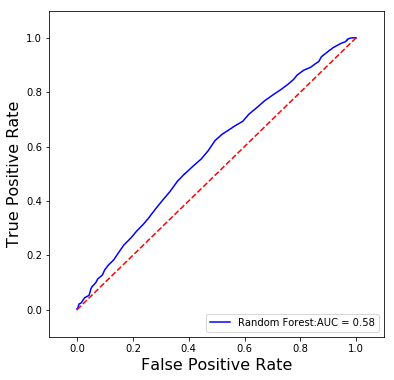

In [19]:
# plot ROC curve for the model
proba_rf = rf.predict_proba(x_test)[:, 1]

fig = plt.figure(figsize = (6, 6))
ax = fig.add_subplot(111) 

ROC_plot(y_test, proba_rf, 'blue', 'Random Forest', ax)

plt.legend(loc='lower right')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate', fontsize = 16)
plt.xlabel('False Positive Rate', fontsize = 16)
plt.show()